- Compute semantic similarity between abstracts and phase descriptions (from phase_desc.json)
- Combine similarity with query-based priors to assign phases
- Analyze phase distributions and confidence

Results:
- Semantic phase probabilities are generally low and close together → weak semantic separation
- Phase 3 (Optimization) becomes dominant for most abstracts when using normal phase_desc.
- Phase 1 is equally dominant when using extended phase_desc.
- Query-based priors strongly influence the final phase assignment, since the semantic separation is so weak.
- The written phase descriptions also becomes too influential. 

Regarding the results:
- This is not necessarily wrong (that most ML-for-manufacturing research focuses on optimization)
- However, clearer and more detailed phase descriptions are likely needed
- A bibliometric clustering step should also be introduced before lifecycle phase mapping to reveal natural topic structure in the literature

In [1]:
# Imports

import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
phase_config_path = Path("../../phases/phase_desc_ext.json")
save_path = processed_abstracts_path / "semantic_analysis"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 52290 abstracts from 24 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."


In [4]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [5]:
# Load phase descriptions from JSON

with phase_config_path.open("r", encoding="utf-8") as f:
    phases = json.load(f)

phase_ids = list(phases.keys())
phase_texts = [phases[p]["description"] for p in phase_ids]

for pid, ptext in zip(phase_ids, phase_texts):
    print(f"{pid}: {ptext[:80]}...")


phase_1: Research and work focused on early conceptual and strategic decisions made befor...
phase_2: Research and work that designs, configures, or executes the core production or s...
phase_3: Research and work that focuses on improving efficiency, performance, quality, re...
phase_4: Research and work focused on the value, behavior, and lifecycle of products duri...


In [6]:
# Phase priors per query_id
# Format: [Phase1_Planning, Phase2_Development/Production, Phase3_Optimization, Phase4_Use/Reuse]

phase_priors = {
    # Use / Reuse — dominant Phase 4
    "ml_inservice_monitoring":       [0.05, 0.20, 0.35, 0.40],
    "ml_remanufacturing":            [0.05, 0.10, 0.15, 0.70],
    "ml_disassembly":                [0.05, 0.25, 0.20, 0.50],
    "ml_end_of_life":                [0.05, 0.10, 0.15, 0.70],
    "ml_recycling_manufacturing":    [0.05, 0.30, 0.20, 0.45],
    "ml_sustainability_product":     [0.30, 0.10, 0.10, 0.50],

    # Very broad — spans production & optimization
    "ml_manufacturing":              [0.10, 0.45, 0.40, 0.05],

    # Planning phase focus
    "ml_planning_production":        [0.75, 0.15, 0.10, 0.00],
    "ml_product_design":             [0.80, 0.15, 0.05, 0.00],
    "ml_plm":                        [0.40, 0.10, 0.15, 0.35],  # lifecycle both ends

    # Development / Production execution focus
    "ml_product_development":        [0.20, 0.60, 0.20, 0.00],
    "ml_defect_detection":           [0.10, 0.65, 0.25, 0.00],
    "ml_quality_control":            [0.05, 0.55, 0.40, 0.00],
    "ml_automation":                 [0.05, 0.70, 0.25, 0.00],
    "ml_robotics_production":        [0.05, 0.75, 0.20, 0.00],

    # Supply chain → planning weighted, but still operational relevance
    "ml_supply_chain":               [0.45, 0.35, 0.15, 0.05],

    # Optimization focused
    "ml_manufacturing_optimization": [0.05, 0.25, 0.70, 0.00],
    "ml_production_optimization":    [0.05, 0.25, 0.70, 0.00],
    "ml_process_optimization":       [0.05, 0.25, 0.70, 0.00],
    "ml_process_control":            [0.05, 0.20, 0.75, 0.00],
    "ml_process_modeling":           [0.10, 0.20, 0.70, 0.00],
    "ml_predictive_maintenance":     [0.05, 0.20, 0.60, 0.15],
    "ml_anomaly_detection_production":[0.05, 0.20, 0.70, 0.05],

    # Use / Reuse specific — RUL informs lifetime while still in operation
    "ml_rul":                        [0.05, 0.15, 0.30, 0.50],
}



def get_phase_prior(query_id):
    # Return a valid probability vector for the query
    prior = phase_priors.get(query_id)
    if prior is None:
        # Default weakly uniform prior if unknown query_id
        prior = np.array([0.25, 0.25, 0.25, 0.25], dtype=float)
    else:
        prior = np.array(prior, dtype=float)
        prior = prior / prior.sum()
    return prior


In [7]:
# Define embedding and similarity helpers (to be implemented with your chosen model)

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")  # In use
light_model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

def get_embedding(text):
    """
    Return a vector 
    ing for the given text.
    Uses a SentenceTransformer model.
    """
    if not isinstance(text, str):
        text = ""
    emb = model.encode(
        text,
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return emb

def cosine_similarity(a, b):
    # Compute cosine similarity between two 1D vectors
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)


In [8]:
# Precompute embeddings for all phase descriptions

phase_embeddings = []
for pid, ptext in zip(phase_ids, phase_texts):
    emb = get_embedding(ptext)
    phase_embeddings.append(emb)

phase_embeddings = np.vstack(phase_embeddings)
phase_embeddings.shape


(4, 768)

In [9]:
# Compute semantic phase scores for each abstract with progress bar

from tqdm import tqdm

sim_cols = ["sim_phase_1", "sim_phase_2", "sim_phase_3", "sim_phase_4"]

# Initialize columns
for col in sim_cols:
    df[col] = np.nan

batch_size = 512  # Adjust based on GPU memory

for start in tqdm(range(0, len(df), batch_size), desc="Embedding abstracts"):
    end = min(start + batch_size, len(df))
    batch = df.iloc[start:end]

    sims = []
    for text in batch["clean_abs"].astype(str).tolist():
        e_abs = get_embedding(text)
        sim_vec = [cosine_similarity(e_abs, pe) for pe in phase_embeddings]
        sims.append(sim_vec)

    sims = np.array(sims)
    exp_sims = np.exp(sims - sims.max(axis=1, keepdims=True))
    probs = exp_sims / exp_sims.sum(axis=1, keepdims=True)

    df.loc[batch.index, sim_cols] = probs

print("Semantic phase scores computed.")
df[sim_cols].head()


Embedding abstracts: 100%|██████████| 65/65 [06:55<00:00,  6.39s/it]

Semantic phase scores computed.


,sim_phase_1,sim_phase_2,sim_phase_3,sim_phase_4
3373,0.281846,0.222217,0.225160,0.270777
3374,0.273081,0.229278,0.221033,0.276608
3392,0.273490,0.220551,0.236455,0.269505
3393,0.254312,0.220582,0.252343,0.272762
3395,0.274521,0.214897,0.218139,0.292443


In [10]:
# Combine query priors and semantic scores into final phase probabilities

alpha = 0.0 # Weight on priors (0=only semantics, 1=only priors)

final_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
df[final_cols] = np.nan

primary_labels = []
secondary_labels = []

for idx, row in df.iterrows():
    prior = get_phase_prior(row["query_id"])
    sem = row[sim_cols].values.astype(float)

    # Safety check for NaN
    if np.any(~np.isfinite(sem)):
        sem = np.ones(4) / 4.0

    combined = alpha * prior + (1 - alpha) * sem
    combined = combined / combined.sum()

    df.loc[idx, final_cols] = combined

    # Determine primary and secondary phases
    order = np.argsort(-combined)  # descending
    primary = order[0] + 1  # 1-based phase index
    secondary = order[1] + 1

    primary_labels.append(primary)
    secondary_labels.append(secondary)

df["primary_phase"] = primary_labels
df["secondary_phase"] = secondary_labels

print("Final phase probabilities and labels added.")
df[["query_id", "primary_phase", "secondary_phase"] + final_cols].head()


Final phase probabilities and labels added.


,query_id,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4
3373,ml_end_of_life,1,4,0.281846,0.222217,0.225160,0.270777
3374,ml_end_of_life,4,1,0.273081,0.229278,0.221033,0.276608
3392,ml_end_of_life,1,4,0.273490,0.220551,0.236455,0.269505
3393,ml_end_of_life,4,1,0.254312,0.220582,0.252343,0.272762
3395,ml_end_of_life,4,1,0.274521,0.214897,0.218139,0.292443


In [11]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_phases.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with phases to: {out_path}")


Saved dataset with phases to: ../../data/processed/abstracts/semantic_analysis/abstracts_with_phases.csv


primary_phase
1    13683
2     3709
3     9552
4     6186
Name: count, dtype: int64


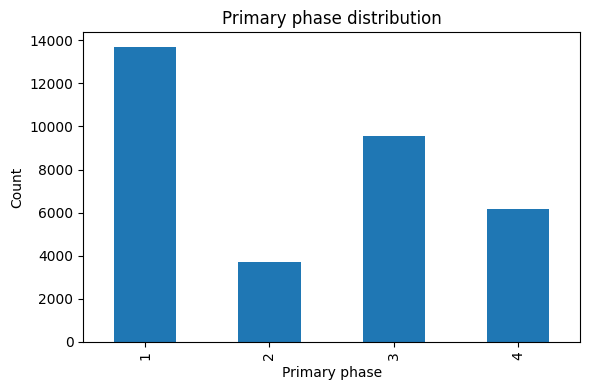

In [12]:
# Plot primary phase distribution

phase_counts = df["primary_phase"].value_counts().sort_index()
print(phase_counts)

plt.figure(figsize=(6,4))
phase_counts.plot(kind="bar")
plt.xlabel("Primary phase")
plt.ylabel("Count")
plt.title("Primary phase distribution")
plt.tight_layout()
plt.show()


In [22]:
# Inspect phase distribution per query_id

phase_query_ct = pd.crosstab(df["query_id"], df["primary_phase"], normalize="index")
phase_query_ct = phase_query_ct.rename(columns=lambda x: f"phase_{x}")

phase_query_ct.head(10)


primary_phase,phase_1,phase_2,phase_3,phase_4
query_id,,,,
ml_anomaly_detection_production,0.054098,0.036066,0.852459,0.057377
ml_automation,0.305253,0.348860,0.242815,0.103072
ml_defect_detection,0.127869,0.086885,0.180328,0.604918
ml_disassembly,0.177122,0.250923,0.387454,0.184502
ml_end_of_life,0.235294,0.000000,0.039216,0.725490
ml_inservice_monitoring,0.110976,0.079268,0.546341,0.263415
ml_manufacturing,0.402093,0.173244,0.218888,0.205775
ml_manufacturing_optimization,0.640305,0.115293,0.123392,0.121010
ml_planning_production,0.638498,0.058099,0.252347,0.051056


In [14]:
# Show queries most dominated by each phase

for p in [1, 2, 3, 4]:
    col = f"phase_{p}"
    print(f"\nTop queries for {col}:")
    display(phase_query_ct[col].sort_values(ascending=False).head(10))



Top queries for phase_1:


query_id
ml_supply_chain                  0.736917
ml_production_optimization       0.652802
ml_manufacturing_optimization    0.640305
ml_planning_production           0.638498
ml_process_optimization          0.636364
ml_sustainability_product        0.600254
ml_product_development           0.599232
ml_product_design                0.578218
ml_process_modeling              0.491551
ml_manufacturing                 0.402093
Name: phase_1, dtype: float64


Top queries for phase_2:


query_id
ml_robotics_production           0.388122
ml_automation                    0.348860
ml_disassembly                   0.250923
ml_process_modeling              0.205837
ml_manufacturing                 0.173244
ml_process_optimization          0.164336
ml_process_control               0.155876
ml_manufacturing_optimization    0.115293
ml_product_design                0.111881
ml_quality_control               0.111720
Name: phase_2, dtype: float64


Top queries for phase_3:


query_id
ml_anomaly_detection_production    0.852459
ml_predictive_maintenance          0.695410
ml_inservice_monitoring            0.546341
ml_process_control                 0.437938
ml_plm                             0.432314
ml_disassembly                     0.387454
ml_rul                             0.291815
ml_quality_control                 0.266156
ml_planning_production             0.252347
ml_process_modeling                0.244240
Name: phase_3, dtype: float64


Top queries for phase_4:


query_id
ml_end_of_life                0.725490
ml_rul                        0.671886
ml_defect_detection           0.604918
ml_recycling_manufacturing    0.582524
ml_remanufacturing            0.535354
ml_sustainability_product     0.309645
ml_quality_control            0.269441
ml_inservice_monitoring       0.263415
ml_predictive_maintenance     0.206885
ml_manufacturing              0.205775
Name: phase_4, dtype: float64

In [15]:
# Compute confidence metrics for phase assignment

df["phase_max_prob"] = df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].max(axis=1)

# Gap between primary and secondary phases
sorted_probs = np.sort(df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].values, axis=1)
df["phase_margin"] = sorted_probs[:, -1] - sorted_probs[:, -2]

df[["primary_phase", "secondary_phase", "phase_max_prob", "phase_margin"]].describe()


,primary_phase,secondary_phase,phase_max_prob,phase_margin
count,33130.000000,33130.000000,33130.000000,3.313000e+04
mean,2.248747,2.433806,0.266383,1.146068e-02
std,1.177442,1.162612,0.007596,9.291308e-03
min,1.000000,1.000000,0.250443,7.979606e-08
25%,1.000000,1.000000,0.260896,4.169562e-03
50%,2.000000,2.000000,0.265459,9.253775e-03
75%,3.000000,3.000000,0.270827,1.655955e-02
max,4.000000,4.000000,0.325480,6.533550e-02


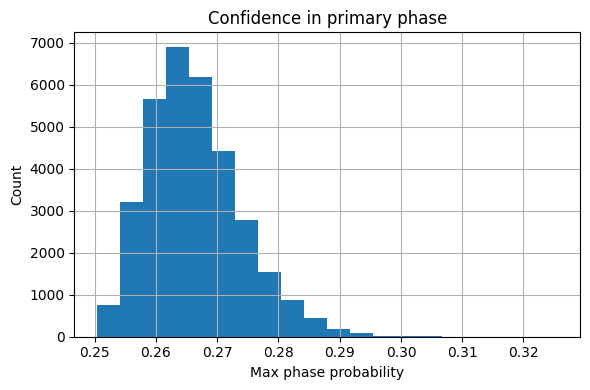

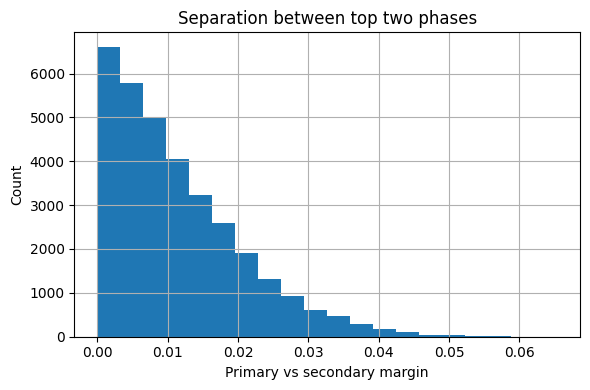

In [16]:
# Plot distributions of confidence and margin

plt.figure(figsize=(6,4))
df["phase_max_prob"].hist(bins=20)
plt.xlabel("Max phase probability")
plt.ylabel("Count")
plt.title("Confidence in primary phase")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
df["phase_margin"].hist(bins=20)
plt.xlabel("Primary vs secondary margin")
plt.ylabel("Count")
plt.title("Separation between top two phases")
plt.tight_layout()
plt.show()


In [17]:
# Inspect low-confidence samples

low_conf_mask = df["phase_max_prob"] < 0.5
print(f"Low-confidence abstracts (<0.5): {low_conf_mask.sum()}")

df_low_conf = df[low_conf_mask].sort_values("phase_max_prob").head(20)
df_low_conf[[
    "query_id",
    "doi",
    "primary_phase",
    "secondary_phase",
    "phase_p1",
    "phase_p2",
    "phase_p3",
    "phase_p4",
    "clean_abs"
]]


Low-confidence abstracts (<0.5): 33130


,query_id,doi,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4,clean_abs
4742,ml_manufacturing,10.1007/s40964-025-01199-x,3,1,0.250427,0.250366,0.250443,0.248765,Fused deposition modeling (FDM) is an additive...
13473,ml_manufacturing,10.1109/LA-CCI58595.2023.10409488,3,1,0.250245,0.249842,0.250516,0.249398,Industrial IoT systems are constantly increasi...
47464,ml_quality_control,10.1007/s11837-020-04408-w,3,1,0.250333,0.250036,0.250596,0.249036,Additive manufacturing (AM) of high-strength m...
16571,ml_manufacturing,10.1007/978-3-030-94507-7_22,1,2,0.250681,0.250506,0.249955,0.248859,"Recently, Internet of Things (IoTs) are in wid..."
2860,ml_defect_detection,10.1109/ICTC55196.2022.9952484,4,2,0.250328,0.250712,0.248237,0.250723,Massive implementation of additive manufacturi...
2440,ml_defect_detection,10.1007/s10845-023-02272-4,2,4,0.249131,0.250733,0.249572,0.250564,Additive Manufacturing (AM) and in particular ...
3664,ml_inservice_monitoring,10.1109/CAC63892.2024.10865625,3,1,0.250155,0.249011,0.250796,0.250038,Unmanned Aerial Vehicles (UAVs) are becoming m...
27607,ml_plm,10.1109/TGRS.2025.3609813,1,3,0.250810,0.249229,0.250623,0.249338,Semantic segmentation in remote sensing (RS) i...
3877,ml_inservice_monitoring,10.3390/app12178427,2,3,0.249511,0.250906,0.250450,0.249132,Recent advances in Artificial Intelligence (AI...
9490,ml_manufacturing,10.1109/JIOT.2024.3352051,1,3,0.250908,0.249623,0.249948,0.249521,Multisource sound localization can find applic...


In [18]:
# Aggregate mean phase probabilities per query_id

phase_prob_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
query_phase_means = df.groupby("query_id")[phase_prob_cols].mean()

query_phase_means.head()


,phase_p1,phase_p2,phase_p3,phase_p4
query_id,,,,
ml_anomaly_detection_production,0.245160,0.244062,0.270821,0.239957
ml_automation,0.254947,0.254660,0.249749,0.240645
ml_defect_detection,0.249192,0.246798,0.247395,0.256616
ml_disassembly,0.252390,0.248736,0.249952,0.248921
ml_end_of_life,0.267638,0.224598,0.230078,0.277687


In [19]:
# Show queries with highest mean probability for each phase

for i, col in enumerate(phase_prob_cols, start=1):
    print(f"\nTop queries by mean {col}:")
    display(query_phase_means[col].sort_values(ascending=False).head(10))



Top queries by mean phase_p1:


query_id
ml_end_of_life                   0.267638
ml_recycling_manufacturing       0.267608
ml_supply_chain                  0.265813
ml_sustainability_product        0.265578
ml_production_optimization       0.264007
ml_planning_production           0.262940
ml_product_development           0.262664
ml_manufacturing_optimization    0.262642
ml_remanufacturing               0.262429
ml_process_optimization          0.261601
Name: phase_p1, dtype: float64


Top queries by mean phase_p2:


query_id
ml_robotics_production           0.255428
ml_automation                    0.254660
ml_process_optimization          0.250816
ml_process_modeling              0.249889
ml_disassembly                   0.248736
ml_manufacturing                 0.248588
ml_process_control               0.248429
ml_manufacturing_optimization    0.247824
ml_plm                           0.246950
ml_defect_detection              0.246798
Name: phase_p2, dtype: float64


Top queries by mean phase_p3:


query_id
ml_anomaly_detection_production    0.270821
ml_predictive_maintenance          0.264700
ml_inservice_monitoring            0.259242
ml_rul                             0.258984
ml_process_control                 0.256334
ml_planning_production             0.254991
ml_plm                             0.252745
ml_process_modeling                0.251942
ml_production_optimization         0.251756
ml_disassembly                     0.249952
Name: phase_p3, dtype: float64


Top queries by mean phase_p4:


query_id
ml_end_of_life                0.277687
ml_recycling_manufacturing    0.270702
ml_remanufacturing            0.266882
ml_rul                        0.266693
ml_sustainability_product     0.258208
ml_defect_detection           0.256616
ml_predictive_maintenance     0.252261
ml_quality_control            0.248994
ml_disassembly                0.248921
ml_inservice_monitoring       0.248909
Name: phase_p4, dtype: float64

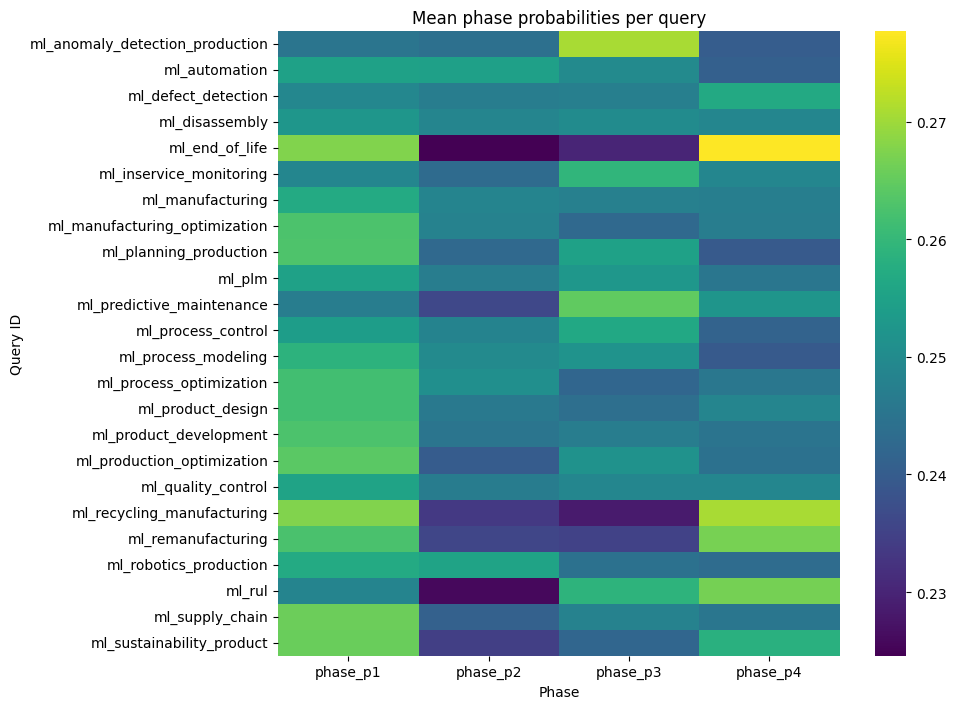

In [20]:
# Plot heatmap of mean phase probabilities per query_id

import seaborn as sns  # if you are OK adding seaborn

plt.figure(figsize=(10, len(query_phase_means) * 0.3))
sns.heatmap(
    query_phase_means[phase_prob_cols],
    annot=False,
    cmap="viridis",
    cbar=True
)
plt.xlabel("Phase")
plt.ylabel("Query ID")
plt.title("Mean phase probabilities per query")
plt.tight_layout()
plt.show()


In [21]:
# Show the most confident abstracts for each phase (primary_phase)
cols_show = [
    "query_id", "doi", "primary_phase", "phase_max_prob", "phase_margin",
    "title", "clean_abs"
]

for p in [1, 2, 3, 4]:
    print(f"\nMost confident Phase {p} abstracts\n")
    
    df_phase = df[df["primary_phase"] == p]
    top_conf = df_phase.sort_values("phase_max_prob", ascending=False).head(5)
    
    display(top_conf[cols_show])



Most confident Phase 1 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
50491,ml_supply_chain,10.1016/j.apenergy.2024.123794,1,0.296568,0.042753,Designing a resilient and sustainable multi-fe...,This paper presents a novel optimization appro...
38517,ml_product_development,10.1504/IJIDS.2024.140188,1,0.294731,0.041627,Hybrid of machine learning-based multiple crit...,Product innovation has become a crucial part o...
39523,ml_production_optimization,10.1021/acs.energyfuels.5c01825,1,0.294567,0.036677,Innovative Wind-Powered System for Liquid Fuel...,Power-to-liquid (PtL) technologies utilizing r...
26363,ml_planning_production,10.1145/3587889.3588213,1,0.294415,0.052687,Application of multi-dimensional clearing func...,This research studies the production release p...
50329,ml_supply_chain,10.1016/j.rser.2025.116402,1,0.294122,0.053851,Anaerobic digestion site-wide optimisation and...,"Currently, AD systems are largely operated con..."



Most confident Phase 2 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
36082,ml_process_modeling,10.1007/978-3-030-06234-7_18,2,0.288416,0.040122,"“Strukturieren, Strukturieren, Strukturieren” ...","While, in the first machine age, physical powe..."
34759,ml_process_control,10.1007/978-3-030-49435-3_28,2,0.287430,0.033594,Resource-Based Adaptive Robotic Process Automa...,Robotic process automation is evolving from ro...
14916,ml_manufacturing,10.1016/j.mfglet.2022.08.013,2,0.286828,0.028402,Physics-aware machine learning surrogates for ...,We believe such a real-time digital twin frame...
2131,ml_automation,10.1007/978-3-030-43687-2_55,2,0.286327,0.030197,AI models and their worlds: Investigating data...,"When we invoke the “future of work,” to whose ..."
35840,ml_process_modeling,10.1145/3571473.3571488,2,0.285955,0.028791,Teaching software processes from different app...,In a current application development scenario ...



Most confident Phase 3 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
73,ml_anomaly_detection_production,10.1007/978-981-96-0576-7_2,3,0.301396,0.050099,Anomaly Detection in Log Streams Based on Time...,2025.Organisations today heavily rely on compl...
684,ml_anomaly_detection_production,10.1007/978-3-319-66379-1_22,3,0.301129,0.053897,A taxonomy of anomalies in distributed cloud s...,Anomaly Detection (AD) in distributed cloud sy...
669,ml_anomaly_detection_production,10.2298/CSIS180126034H,3,0.300502,0.046456,The CRI-model: A domain-independent taxonomy f...,All rights reserved.Anomaly detection is the p...
187,ml_anomaly_detection_production,10.1109/TPDS.2024.3365462,3,0.300357,0.055770,Runtime Performance Anomaly Diagnosis in Produ...,With the increasing scale and complexity of Hi...
609,ml_anomaly_detection_production,10.1109/ACCESS.2020.3015346,3,0.300357,0.047669,TRACK-Plus: Optimizing Artificial Neural Netwo...,Software applications can feature intrinsic va...



Most confident Phase 4 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
3367,ml_end_of_life,10.3390/su17125511,4,0.325480,0.060018,Review and Novel Framework with Hui–Walter Met...,Consumers’ growing interest in sustainability ...
51870,ml_sustainability_product,10.1109/ICASI60819.2024.10547722,4,0.313736,0.050019,Remaining Value Estimation of Smartphones Appl...,The composition of increasing attention to sus...
47896,ml_remanufacturing,10.1016/j.wasman.2014.11.024,4,0.311236,0.042271,An investigation of used electronics return fl...,Consumers often have a tendency to store their...
11067,ml_manufacturing,10.1109/ACCESS.2024.3432394,4,0.310552,0.065336,A Review of Degradation and Reliability Analys...,"Affordability, Long-term warranty, scalability..."
15087,ml_manufacturing,10.3390/en15165964,4,0.307597,0.064129,Solar Photovoltaic Modules’ Performance Reliab...,The current geometric increase in the global d...
